<a href="https://colab.research.google.com/github/toledojm/josetoledo_datathon/blob/main/josetoledo_datathon_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATATHON JOSE TOLEDO DATA-03
## Predicción de envios a tiempo de una empresa de logística de E-commerce



se importan los modulos con las librerias necesarias

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

from sklearn.pipeline import Pipeline

from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

se importan los datasets desde el repo de github

In [65]:
ECommerce_test_url = 'https://github.com/toledojm/Datathon/blob/main/E-Commerce_test.xlsx?raw=true'
ECommerce_train_url ='https://github.com/toledojm/Datathon/blob/main/E-Commerce_train.xlsx?raw=true'

In [66]:
df_evaluador= pd.read_excel(ECommerce_train_url)
df_predictor= pd.read_excel(ECommerce_test_url)

## Descripción de las dimensiones

- ID: identificador del registro de orden (valor entero).
- Warehouse_block: Almacén de distribución de donde salió la orden (A a F).
- Mode_of_Shipment: Medio de transporte (Flight, Road, Ship).
- Customer_care_calls: Número de llamadas a atención al cliente que hubo por esa orden. (valores enteros del 2 al 7)
- Customer_rating: Puntaje del cliente (valores enteros 1 al 5).
- Cost_of_the_Product: Costo del producto (valor numérico entero de 96 a 310).
- Prior_purchases: Número de compras previas realizadas por el cliente (valor numérico entero de 2 a 10).
- Product_importance: Nivel de importancia del producto (low, medium, high).
- Gender: Género del comprador (F, M).
-Discount_offered: Porcentaje de descuento ofrecido por esa compra (valor numérico entero de 1 a 65):
- Weight_in_gms: Peso del paquete de la orden, en gramos (valor numérico entero de 1001 a 7846).
- Reached.on.Time_Y.N: Información sobre la llegada del paquete a destino (1 si llegó a tiempo, 0 si no llegó a tiempo).


# COMIENZO DEL EDA

descripción archivo: 'E-Commerce_test.xlsx', 2000 observaciones y 11 dimensiones, sin incluir información sobre si el envío llegó a tiempo o no en el momento del registro.

In [67]:
df_evaluador.info() # chequeo el tipo de dato según la descripción de dimensiones

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8999 entries, 0 to 8998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   8999 non-null   int64 
 1   Warehouse_block      8999 non-null   object
 2   Mode_of_Shipment     8999 non-null   object
 3   Customer_care_calls  8999 non-null   int64 
 4   Customer_rating      8999 non-null   int64 
 5   Cost_of_the_Product  8999 non-null   int64 
 6   Prior_purchases      8999 non-null   int64 
 7   Product_importance   8999 non-null   object
 8   Gender               8999 non-null   object
 9   Discount_offered     8999 non-null   int64 
 10  Weight_in_gms        8999 non-null   int64 
 11  Reached.on.Time_Y.N  8999 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 843.8+ KB


no se obseraban valores faltantes ni nulos para el archivo para entrenamiento de los modelos

descripción archivo: 'E-Commerce_train.xlsx', 8999 observaciones y 12 dimensiones, incluyendo información sobre si el envío llegó a tiempo o no en el momento del registro.

In [ ]:
df_predictor.info() # chequeo el tipo de dato según la descripción de dimensiones

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2000 non-null   int64 
 1   Warehouse_block      2000 non-null   object
 2   Mode_of_Shipment     2000 non-null   object
 3   Customer_care_calls  2000 non-null   int64 
 4   Customer_rating      2000 non-null   int64 
 5   Cost_of_the_Product  2000 non-null   int64 
 6   Prior_purchases      2000 non-null   int64 
 7   Product_importance   2000 non-null   object
 8   Gender               2000 non-null   object
 9   Discount_offered     2000 non-null   int64 
 10  Weight_in_gms        2000 non-null   int64 
dtypes: int64(7), object(4)
memory usage: 172.0+ KB


no se obseraban valores faltantes ni nulos en el archivo para p¡la predicción final

In [108]:
print('La cantidad de registros duplicados es:', df_evaluador.duplicated().sum()) # reviso observaciones duplicadas
print('La cantidad de registros duplicados es:', df_predictor.duplicated().sum()) # reviso observaciones duplicadas

La cantidad de registros duplicados es: 0
La cantidad de registros duplicados es: 0


no se observan valores duplicados

In [109]:
print('cantidad de envios a tiempo',df_evaluador["Reached.on.Time_Y.N"].sum())
print('porcentaje de envios a tiempo',round(df_evaluador["Reached.on.Time_Y.N"].sum()/df_evaluador["Reached.on.Time_Y.N"].count()*100,2),'%')

cantidad de envios a tiempo 5719
porcentaje de envios a tiempo 63.55 %


 la variable a predecir esta desbalanceada

In [110]:
# divido los datos aleatoreamente en dos subsets 70% en df_train para entrenar el modelo
# y 30% en df_test para testeo final

array_train, array_test = train_test_split(df_evaluador, test_size = 0.30, random_state = 42)

df_train=pd.DataFrame(array_train)
df_test=pd.DataFrame(array_test)

se evalua los procetajes de desbanalce

In [111]:
print('cantidad de envios a tiempo para el set de entrenamiento',df_train["Reached.on.Time_Y.N"].sum())
print('porcentaje de envios a tiempo para el set de entrenamiento',round(df_train["Reached.on.Time_Y.N"].sum()/df_train["Reached.on.Time_Y.N"].count()*100,2),'%')

print('cantidad de envios a tiempo para el set de evaluación',df_test["Reached.on.Time_Y.N"].sum())
print('porcentaje de envios a tiempo para el set de evaluación',round(df_test["Reached.on.Time_Y.N"].sum()/df_test["Reached.on.Time_Y.N"].count()*100,2),'%')


cantidad de envios a tiempo para el set de entrenamiento 3963
porcentaje de envios a tiempo para el set de entrenamiento 62.91 %
cantidad de envios a tiempo para el set de evaluación 1756
porcentaje de envios a tiempo para el set de evaluación 65.04 %


se crea un dataset balanceado para aplicar los modelos

In [112]:
mask = df_train["Reached.on.Time_Y.N"] == 0
mask.sum()
df_train[~mask].sample(n = 4)
df_subsample = pd.concat([df_train[mask], df_train[~mask].sample(n = mask.sum())])
df_subsample = df_subsample.sample(frac=1,  random_state=42).reset_index(drop=True)

In [113]:
mask = df_test["Reached.on.Time_Y.N"] == 0
mask.sum()
df_test[~mask].sample(n = 4)
df_subsample_test = pd.concat([df_test[mask], df_test[~mask].sample(n = mask.sum())])
df_subsample_test = df_subsample.sample(frac=1,  random_state=42).reset_index(drop=True)

In [114]:
print('cantidad de envios a tiempo para el set de evaluación',df_subsample["Reached.on.Time_Y.N"].sum())
print('porcentaje de envios a tiempo para el set de evaluación',round(df_subsample["Reached.on.Time_Y.N"].sum()/df_subsample["Reached.on.Time_Y.N"].count()*100,2),'%')


cantidad de envios a tiempo para el set de evaluación 2336
porcentaje de envios a tiempo para el set de evaluación 50.0 %


creo los datasets:
- data=variables que van  apredecir el target
- taget=variable a predecir. envios que llegan a tiempo valor=1 o no valor=0.

In [74]:
#creo los datasets de entrenamiento
data=df_subsample.drop(['ID',"Reached.on.Time_Y.N",'Gender'], axis=1) # a la vista las variables ID y Gender no me aportan información importante
target=df_subsample["Reached.on.Time_Y.N"]


In [115]:
#creo los datasets de evaluación
data_evaluacion=df_subsample_test.drop(['ID',"Reached.on.Time_Y.N",'Gender'], axis=1) # a la vista las variables ID y Gender no me aportan información importante
target_evaluacion=df_subsample_test["Reached.on.Time_Y.N"]

se listan las variables categóricas y las numéricas para su tratamento específico

In [116]:
num_col_selector = selector(dtype_exclude=object) # selector de variables numéricas
cat_col_selector = selector(dtype_include=object) # selector de variables categóricas

num_col = num_col_selector(data) # lista de variables numéricas
cat_col = cat_col_selector(data) # lista de variables categóricas

se crea el preprosesamiento de los datos según su categoría

In [117]:
numeric_transformer = Pipeline([('scaler', MinMaxScaler())]) # Transformaciones para las variables numéricas

categorical_transformer = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))]) # Transformaciones para las variables categóricas

preprocessor= ColumnTransformer(transformers=[('numeric', numeric_transformer, num_col),
                                              ('categoric', categorical_transformer, cat_col)])



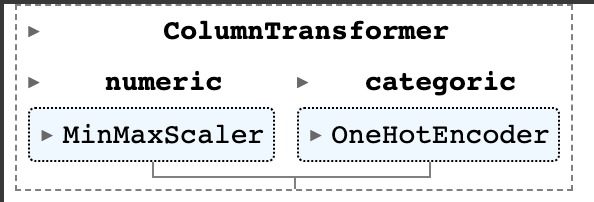

se convierten los dataframes añadiendo las columnas categoricas con el encoder de sus respectivos nombres y  se escalan las numericas


In [118]:
preprocessor.fit(data)
encoded_cat = preprocessor.named_transformers_['categoric']['onehot']\
              .get_feature_names_out(cat_col)
labels = np.concatenate([num_col, encoded_cat])
datos_train_prep = preprocessor.transform(data)
datos_train_prep = pd.DataFrame(datos_train_prep, columns=labels)

In [119]:
preprocessor.fit(data_evaluacion)
encoded_cat = preprocessor.named_transformers_['categoric']['onehot']\
              .get_feature_names_out(cat_col)
labels = np.concatenate([num_col, encoded_cat])
datos_test_prep = preprocessor.transform(data_evaluacion)
datos_test_prep = pd.DataFrame(datos_test_prep, columns=labels)

In [120]:
preprocessor.fit(df_predictor)
encoded_cat = preprocessor.named_transformers_['categoric']['onehot']\
              .get_feature_names_out(cat_col)
labels = np.concatenate([num_col, encoded_cat])
datos_predictor = preprocessor.transform(df_predictor)
datos_predictor = pd.DataFrame(datos_predictor, columns=labels)

se visualiza mendiante la matriz de correlación las variables que genenar ruido o se encuentran relacionadas con otras

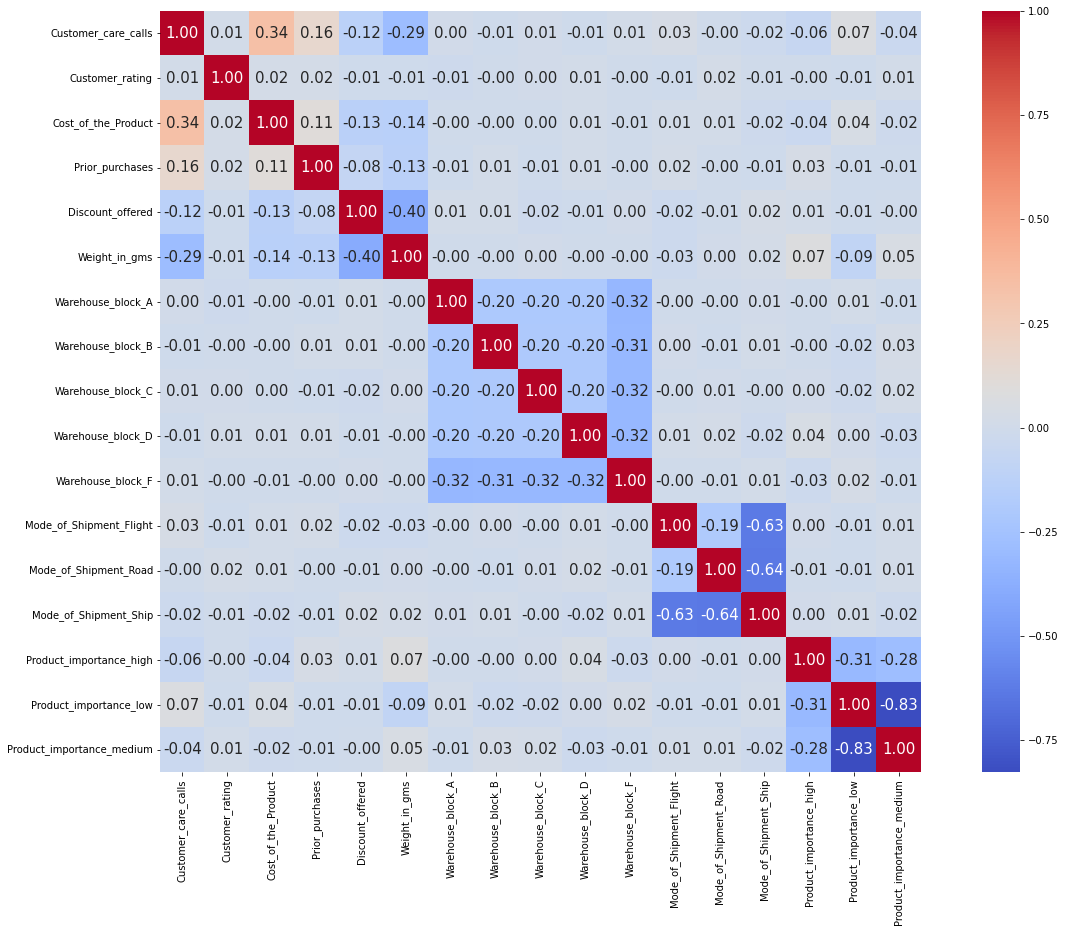

In [ ]:
corr = datos_train_prep.corr(method='pearson')
plt.figure(figsize=(22,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= datos_train_prep.columns, 
           yticklabels= datos_train_prep.columns,
           cmap= 'coolwarm')
plt.show()

se elimina las variables correlacionadas o con ruido

In [121]:
datos_train_prep.drop(['Product_importance_medium','Warehouse_block_F'], axis=1, inplace=True) # se dropean las variables irrelevantes, con ruido o muy relacionadas

In [122]:
datos_test_prep.drop(['Product_importance_medium','Warehouse_block_F'], axis=1, inplace=True)

In [123]:
datos_predictor.drop(['Product_importance_medium','Warehouse_block_F'], axis=1, inplace=True)

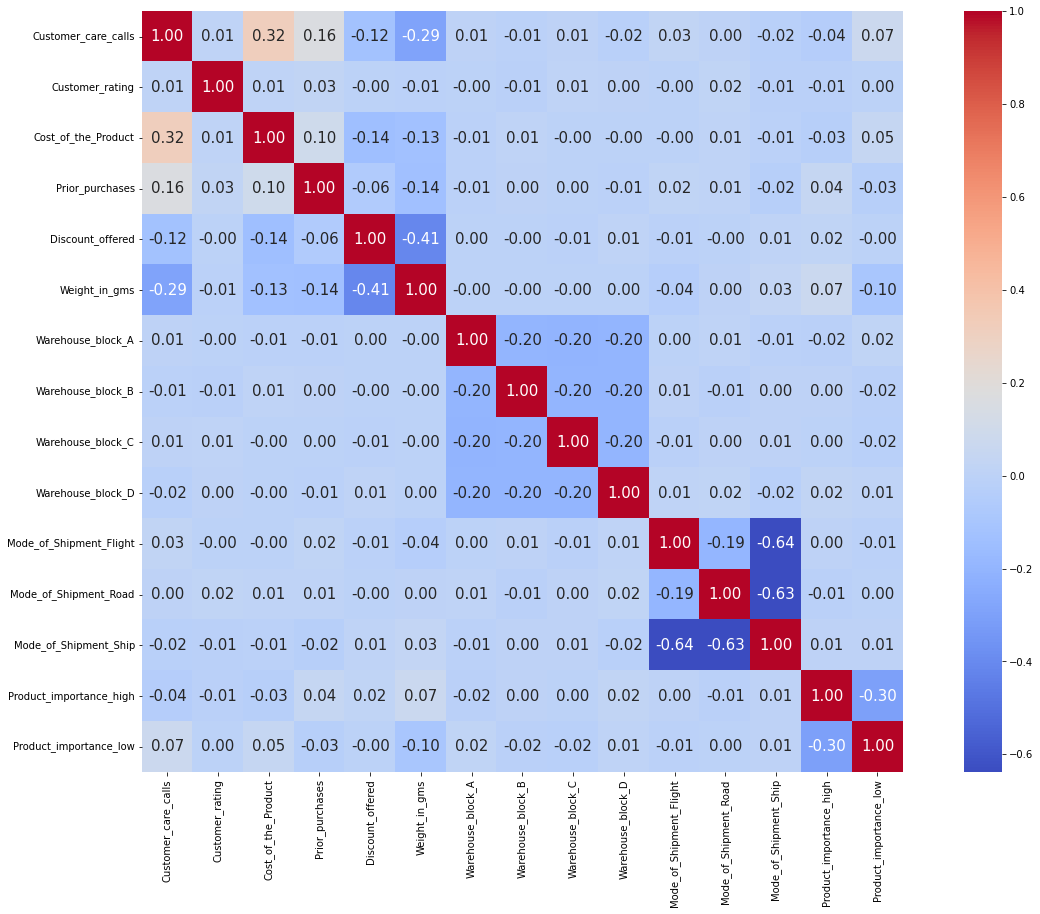

In [ ]:
corr = datos_train_prep.corr(method='pearson')
plt.figure(figsize=(22,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= datos_train_prep.columns, 
           yticklabels= datos_train_prep.columns,
           cmap= 'coolwarm')
plt.show()

se crean los sets de entrenamiento y testeo

In [90]:
data_train, data_test, target_train, target_test = train_test_split(datos_train_prep,target,test_size = 0.3, random_state=42, stratify=target)

## finaliza el EDA y comienza la busqueda del modelo predictor

se buscan los mejores parámetros para diferentes modelos a testear

In [ ]:
model_lr = LogisticRegression()
model_svc= SVC()
model_knn = KNeighborsClassifier()
model_rfc = RandomForestClassifier()
model_hgbc = HistGradientBoostingClassifier()
model_lr = LogisticRegression()

In [ ]:
params_knn = [{'n_neighbors': [ 5, 7, 9,11,13,15],
         'weights': ['uniform', 'distance'],
         'leaf_size': [7,15, 20]}]
gs_knn = GridSearchCV(model_knn ,
                      param_grid=params_knn,
                      scoring='accuracy',
                      cv=5)
gs_knn.fit(data_train, target_train)
gs_knn.best_params_

{'leaf_size': 7, 'n_neighbors': 13, 'weights': 'distance'}

In [ ]:
params_rfc = { 'n_estimators': [100,200,300],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [5,6,7,8,9],
                'criterion' :['gini', 'entropy']}
 
gs_rfc = GridSearchCV(model_rfc ,
                      param_grid=params_rfc,
                      scoring='accuracy',
                      cv=5)
gs_rfc.fit(data_train, target_train)
gs_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [ ]:
params_svc = {'C': [0.1,1.0, 5.0], 
              'gamma': [1,0.1,0.01],
              'kernel': ['rbf', 'poly', 'sigmoid']}
gs_svc = GridSearchCV(model_svc ,
                      param_grid=params_svc,
                      scoring='accuracy',
                      cv=3,n_jobs=-1)
gs_svc.fit(data_train, target_train)
gs_svc.best_params_

{'C': 5.0, 'gamma': 0.1, 'kernel': 'rbf'}

In [ ]:
params_hgbc= {
    'learning_rate': (0.01, 0.1, 1, 10),
    'max_leaf_nodes': (3, 10, 30)}
gs_hgbc = GridSearchCV(model_hgbc ,
                      param_grid=params_hgbc,
                      scoring='accuracy',
                      cv=5)
gs_hgbc.fit(data_train, target_train)
gs_hgbc.best_params_

{'learning_rate': 0.01, 'max_leaf_nodes': 10}

con los mejores parametros se buscan los mejores modelos

In [ ]:
from sklearn.decomposition import PCA

In [126]:
clf_lr = Pipeline([('pca',PCA(n_components=4)),('lr',LogisticRegression())])
clf_svc= Pipeline([('pca',PCA(n_components=4)),('svc',SVC(C= 5.0, gamma= 0.01, kernel='rbf'))])
clf_knn = Pipeline([('pca',PCA(n_components=4)),('knn',KNeighborsClassifier(leaf_size= 7, n_neighbors= 13, weights='distance'))])
clf_rfc = Pipeline([('pca',PCA(n_components=4)),('rfc',RandomForestClassifier(criterion= 'gini',max_depth=5,max_features='auto',n_estimators= 100))])
clf_hgbc = Pipeline([('pca',PCA(n_components=4)),('hgbc',HistGradientBoostingClassifier(learning_rate= 0.01, max_leaf_nodes= 10))])

In [128]:
clf_lr = Pipeline([('lr',LogisticRegression())])
clf_svc= Pipeline([('svc',SVC(C= 5.0, gamma= 0.01, kernel='rbf'))])
clf_knn = Pipeline([('knn',KNeighborsClassifier(leaf_size= 7, n_neighbors= 13, weights='distance'))])
clf_rfc = Pipeline([('rfc',RandomForestClassifier(criterion= 'gini',max_depth=5,max_features='auto',n_estimators= 100))])
clf_hgbc = Pipeline([('hgbc',HistGradientBoostingClassifier(learning_rate= 0.01, max_leaf_nodes= 10))])

In [129]:
pipelines = [clf_svc, clf_knn,clf_rfc,clf_hgbc]


pipe_dict = { 0: 'SVM', 1: 'knn-vecinos', 2:'Random Forest Clasificador',3:'Gradient Boosting Classifier'}


for pipe in pipelines:
	pipe.fit(data_train, target_train)
 # Evaluamos

for idx, val in enumerate(pipelines):
	print('%s pipeline accuracy en test: %.3f' % (pipe_dict[idx], val.score(data_test, target_test)))

SVM pipeline accuracy en test: 0.730
knn-vecinos pipeline accuracy en test: 0.692
Random Forest Clasificador pipeline accuracy en test: 0.763
Gradient Boosting Classifier pipeline accuracy en test: 0.765


con los dos mejores modelos se apilan y se predice con el metamodelo

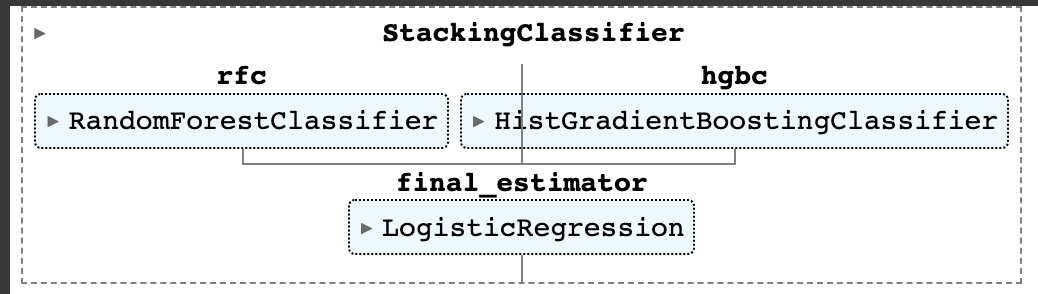

In [130]:
kf = KFold(n_splits=5)

estimator_list=[ 
            ('rfc', clf_rfc), 
            ('hgbc', clf_hgbc)]

# Se genera el modelo apilado (stacking)
# Se estima con los 2 mejores modelos
# se utiliza como estimador de la predicción final una regresión logística (metamodelo)
stack_model = StackingClassifier(estimators=estimator_list, final_estimator=LogisticRegression())

# Se entrena el metamodelo
stack_model.fit(data_train, target_train)
 
score = stack_model.score(data_train, target_train)
print("Metrica del modelo", score)
scores = cross_val_score(stack_model, data_train, target_train, cv=kf, scoring="accuracy")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())
preds = stack_model.predict(data_test)
score_pred = metrics.accuracy_score(target_test, preds)
print("Metrica en Test", score_pred)

Metrica del modelo 0.7672782874617737
Metricas cross_validation [0.74770642 0.74617737 0.7675841  0.75076453 0.78440367]
Media de cross_validation 0.7593272171253822
Metrica en Test 0.7631954350927247


In [131]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(target_test, preds))

[[685  16]
 [316 385]]


In [132]:
from sklearn.metrics import recall_score

In [133]:
recall=recall_score(target_test, preds)
recall

0.5492154065620543

se evaluan los datos que se dejaron sin entrenar para ver su performance

In [134]:
stack_model.fit(datos_test_prep, target_evaluacion)
# Predecimos sobre todas las instancias que no vio
target_test_pred = stack_model.predict(datos_test_prep)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(target_test_pred,target_evaluacion))

Accuracy sobre conjunto de Train: 0.7756849315068494


In [135]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(target_test, preds))

[[685  16]
 [316 385]]


In [136]:
recall=recall_score(target_test_pred,target_evaluacion)
recall

0.9626436781609196

In [137]:
df_target=pd.DataFrame(target_test_pred)
df_target.value_counts()


0    3280
1    1392
dtype: int64

finalmente se predice los datos que se tenian para este fin

In [138]:
#Predecimos en los datos de test con el mejor modelo obtenido
prediction = pd.DataFrame(stack_model.predict(datos_predictor), columns=['pred'])


In [139]:
prediction.value_counts()

pred
1       1650
0        350
dtype: int64

se exporta a csv las predicciones

In [143]:
prediction.to_csv('toledojm.csv',index=False)
!cp toledojm.csv "/content/drive/MyDrive/Datathon"

# FIN